<a href="https://colab.research.google.com/github/kruttikajain/Targetted-Abusive_Language_Online/blob/master/prediction1_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abusive Language Online 

Predition1: predict OFF/NOT

* Upload it each time: Dataset: [data](http://demo.clab.cs.cmu.edu/ethical_nlp2019/homeworks/hw3/hw3.html)


1.   train.tsv
2.   dev.tsv
3.   test.tsv

* Need manually add log.txt
* Mount drive to load GloVe embeddings




# Import useful lib

In [1]:
import os
import sys
from logging import handlers
from pathlib import Path
import logging
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
import random 

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, CuDNNLSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline 
import matplotlib.pyplot as plt

Using TensorFlow backend.


# Data proprecessing

## mounting drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pwd

/content


In [4]:
# Clone github repository setup
# import join used to join ROOT path and MY_GOOGLE_DRIVE_PATH
from os.path import join  

# path to your project on Google Drive
MY_GOOGLE_DRIVE_PATH = '' 
# replace with your Github username 
GIT_USERNAME = "kruttikajain" 
# definitely replace with your
GIT_TOKEN = "5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c"  
# Replace with your github repository in this case we want 
# to clone deep-learning-v2-pytorch repository
GIT_REPOSITORY = "Targetted-Abusive_Language_Online" 

# PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

'''
only this line should be modify
'''
PROJECT_PATH = './gdrive/My Drive/Colab Notebooks/246Project'

# It's good to print out the value if you are not sure 
print("PROJECT_PATH: ", PROJECT_PATH)   

# In case we haven't created the folder already; we will create a folder in the project path 
!mkdir "{PROJECT_PATH}"    

#GIT_PATH = "https://{GIT_TOKEN}@github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git" this return 400 Bad Request for me
GIT_PATH = "https://" + GIT_TOKEN + "@github.com/" + GIT_USERNAME + "/" + GIT_REPOSITORY + ".git"
print("GIT_PATH: ", GIT_PATH)

PROJECT_PATH:  ./gdrive/My Drive/Colab Notebooks/246Project
mkdir: cannot create directory ‘./gdrive/My Drive/Colab Notebooks/246Project’: File exists
GIT_PATH:  https://5fae1c9f18e3a0c680bf35e9ef63c72308ef2b4c@github.com/kruttikajain/Targetted-Abusive_Language_Online.git


## Prepare logging file

In [5]:
def init_logger(log_file):
    if not os.path.exists(log_file):
        os.makedirs(os.path.dirname(log_file))

    log = logging.getLogger('')
    log.setLevel(logging.INFO)
    output_format = logging.Formatter(fmt='%(asctime)s %(levelname)-8s %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    std_out_handler = logging.StreamHandler(sys.stdout)
    std_out_handler.setFormatter(output_format)
    logging.getLogger().addHandler(std_out_handler)
    file_handler = logging.handlers.RotatingFileHandler(log_file, maxBytes=(1048576*5), backupCount=7)
    file_handler.setFormatter(output_format)
    logging.getLogger().addHandler(file_handler)

init_logger(PROJECT_PATH + '/log.txt')
logging.info('=============start2=================')
logging.info('logging file prepared...')

2020-05-16 20:18:42 INFO     =============start2=================
2020-05-16 20:18:43 INFO     logging file prepared...


## load data

In [6]:
def load_data():
    logging.info('loading the dataset...')
    train_df = pd.read_csv(PROJECT_PATH + '/project_data/train.tsv', sep="\t")
    val_df = pd.read_csv(PROJECT_PATH + '/project_data/dev.tsv', sep="\t")
    test_df = pd.read_csv(PROJECT_PATH + '/project_data/test.tsv', sep="\t")
    
    # shape of df, column names
    logging.info('Train shape : ' + str(train_df.shape)) # 'text', 'label', 'category'
    logging.info('Val shape: ' + str(val_df.shape))
    logging.info('Test shape: ' + str(test_df.shape))
    
    logging.info('train_df.columns: ' + train_df.columns)
    logging.info('val_df.columns: ' + val_df.columns)
    logging.info('test_df.columns: ' + test_df.columns)

    return train_df, val_df, test_df

train_df, val_df, test_df = load_data()

2020-05-16 20:18:45 INFO     loading the dataset...
2020-05-16 20:18:46 INFO     Train shape : (10592, 3)
2020-05-16 20:18:46 INFO     Val shape: (1324, 3)
2020-05-16 20:18:46 INFO     Test shape: (1324, 1)
2020-05-16 20:18:46 INFO     NumExpr defaulting to 2 threads.
2020-05-16 20:18:46 INFO     Index(['train_df.columns: text', 'train_df.columns: label',
       'train_df.columns: category'],
      dtype='object')
2020-05-16 20:18:46 INFO     Index(['val_df.columns: text', 'val_df.columns: label',
       'val_df.columns: category'],
      dtype='object')
2020-05-16 20:18:46 INFO     Index(['test_df.columns: text'], dtype='object')


In [7]:
train_df.head()

,text,label,category
0,@USER @USER You are an embarrassing citizen!!,OFF,TIN
1,@USER Seems hard to believe that you stood nex...,OFF,TIN
2,@USER @USER @USER Wow !!! no wonder the Libera...,OFF,TIN
3,@USER @USER And not all idiots grandstands lik...,OFF,TIN
4,@USER Bring on the hypocrite gungrabber. MAGA,OFF,TIN


**Attributes in data:**


***Trainning data:***  (10592, 3) \\

* **text:** \\
tweet content

* **label:** \\
1.   (NOT) Not Offensive - This post does not contain offense or profanity
2.   (OFF) Offensive - This post contains offensive language or a targeted (veiled or direct) offense

* **category:** (if label is 'OFF') \\
1.   (TIN) Targeted Insult and Threats - A post containing an insult or threat to an individual, a group, or others
2.   (UNT) Untargeted - A post containing non-targeted profanity and swearing.

***Validation data:***  (1324, 3) \\

***Testing data***:  'text' (1324, 1) \\
* **text**

## Data cleaning

In [0]:
def data_cleaning(train_df, val_df, test_df):
    # shuffle data
    train_df = train_df.sample(frac=1, random_state=2020).reset_index(drop=True)
    
    # lo lowercae
    train_df['text'] = train_df['text'].str.lower()
    val_df['text'] = val_df['text'].str.lower()
    test_df['text'] = test_df['text'].str.lower()

    # delete "noise words"
    noise = ["url","user","@","&amp;","#","-",'.',"!","?","rt","dm","retweet","rt","dm"]
    for WORD in noise:
        train_df['text'] = train_df['text'].str.replace(WORD, '')
        val_df['text'] = val_df['text'].str.replace(WORD, '')
        test_df['text'] = test_df['text'].str.replace(WORD, '')

    # change label to 0/a
    train_df['label'] = train_df['label'].map({'OFF': 1, 'NOT': 0})
    val_df['label'] = val_df['label'].map({'OFF': 1, 'NOT': 0})

    # one-hot encoding of category
    train_df = pd.concat([train_df,pd.get_dummies(train_df['category'], prefix='category')],axis=1)
    train_df.drop(['category'],axis=1, inplace=True)
    
    val_df = pd.concat([val_df,pd.get_dummies(val_df['category'], prefix='category')],axis=1)
    val_df.drop(['category'],axis=1, inplace=True)
    return train_df, val_df, test_df

train_df, val_df, test_df = data_cleaning(train_df, val_df, test_df)


In [9]:
val_df.head(10)

,text,label,category_TIN,category_UNT
0,she should ask a few native americans what th...,1,0,1
1,go home you’re drunk maga trump2020 👊🇺🇸👊,1,1,0
2,amazon is investigating chinese employees who ...,0,0,0
3,"someone should'vetaken"" this piece of shit to...",1,0,1
4,obama wanted liberals illegals to move into...,0,0,0
5,liberals are all kookoo,1,1,0
6,oh noes tough shit,1,0,1
7,was literally just talking about this lol all...,1,1,0
8,buy more icecream,0,0,0
9,canada doesn’t need another cuck we already h...,1,1,0


Check the content of abusive text

In [10]:
abusive_df = train_df.loc[train_df['label'] == 1]
pd.set_option('display.max_colwidth', -1)
abusive_df['text'].head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


0      didn't this trashy thing sleep her way to the top with married men                                                                 
1       gfy the nfl should get no protection from the policeand no suppo from our militarythe league will slowly die on this road of shame
10     👀 sitting here thinking he has a killer porn stache                                                                                
13    all trump's and pense 2020 merch is being made is china and not the usa    maga    votethemout2018  trumpsarmy                      
16     gun control now enough is enough                                                                                                   
Name: text, dtype: object

## Data distribution and visualization 

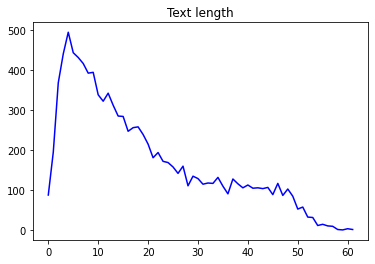

2020-05-16 20:19:58 INFO     number of label = 1 : 3520
2020-05-16 20:19:58 INFO     number of category_TIN = 1: 3089
2020-05-16 20:19:58 INFO     number of category_UNT = 1: 431


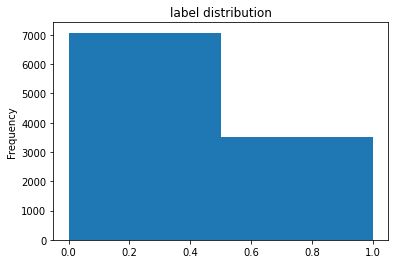

In [11]:
# count how many letters in a sentence
def label_distribution(train_df):
    #  length of text
    count = train_df['text'].str.split().apply(len).value_counts()
    count.sort_index(inplace=True)
    count.index = count.index.astype(str) + ' words:'
    # logging.info(count[0:5])
    # logging.info(count[-5:])
    plt.plot(range(len(count)), count, color='blue')
    plt.title("Text length")
    plt.show()
    # label distribution
    logging.info('number of label = 1 : ' + str((train_df['label'] != 0).sum()))
    logging.info('number of category_TIN = 1: ' + str((train_df['category_TIN'] != 0).sum()))
    logging.info('number of category_UNT = 1: ' + str((train_df['category_UNT'] != 0).sum()))

    # plot histogram
    train_df['label'].plot.hist(bins=2, title='label distribution')
    plt.show()

label_distribution(train_df)


**Property of dataset**

*   **Length of text:** [2, 60]

*   **label:** 
1.   label = 0: 7072
2.   label = 1: 3520

* Among label = 1: \\
1.   category_TIN = 1: 3089
2.   category_UNT = 1: 431



# Split data to X and y

Split data to X and y

In [12]:
def split_train_val(train_df, val_df, test_df):
    logging.info('splitting X and y ...')
    train_X = train_df["text"].fillna("_na_").values
    val_X = val_df["text"].fillna("_na_").values
    test_X = test_df["text"].fillna("_na_").values

    train_y = train_df['label'].values
    val_y = val_df['label'].values

    logging.info('finished splitting X and y')
    return train_X, val_X, test_X, train_y, val_y

train_X, val_X, test_X, train_y, val_y = split_train_val(train_df, val_df, test_df)

2020-05-16 20:20:16 INFO     splitting X and y ...
2020-05-16 20:20:16 INFO     finished splitting X and y


In [13]:
print(train_X.shape, train_y.shape)
print(val_X.shape, val_y.shape)

(10592,) (10592,)
(1324,) (1324,)


Tokenize and padding each sentence, split datafram to attributes and labels

In [14]:
# each word embedding to 300 dimension
embed_size = 300
# count of vocabulary words
max_features = 50000
# length of each sentences
max_len = 70

def token_sentence(train_X, val_X, test_X ):
    logging.info('tokenizing sentence...')
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)
    test_X = tokenizer.texts_to_sequences(test_X)

    logging.info('padding sentence...')
    train_X = pad_sequences(train_X, maxlen=max_len)
    val_X = pad_sequences(val_X, maxlen=max_len)
    test_X = pad_sequences(test_X, maxlen=max_len)

    logging.info('all finished...')
    return train_X, val_X, test_X, tokenizer

train_X, val_X, test_X, tokenizer = token_sentence(train_X, val_X, test_X)


2020-05-16 20:20:27 INFO     tokenizing sentence...
2020-05-16 20:20:27 INFO     padding sentence...
2020-05-16 20:20:28 INFO     all finished...


In [15]:
train_X.shape

(10592, 70)

# Train model

## Model1: base line

In [0]:
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# precision is the ratio tp / (tp + fp)
# recall is the ratio tp / (tp + fn)
# F1 = 2 * (precision * recall) / (precision + recall)

### LogisticRegression

In [0]:
def lr_model(train_X, train_y, val_X, cal_y):
    lr_clf = LogisticRegression(random_state=0, max_iter=4000).fit(train_X, train_y)
    pred_val_y = lr_clf.predict(val_X).reshape(-1,1)

    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lr_acc = accuracy_score(pred_val_y, val_y)
    lr_precision = precision_score(pred_val_y, val_y)
    lr_recall = recall_score(pred_val_y, val_y)
    lr_f1_score = f1_score(pred_val_y, val_y)
    return lr_acc, lr_precision, lr_recall, lr_f1_score

lr_acc, lr_precision, lr_recall, lr_f1_score = lr_model(train_X, train_y, val_X, val_y)
print('lr_precision', lr_precision, 'lr_recall', lr_recall)
print('lr_acc: ', lr_acc, ', lr_f1_score: ',  lr_f1_score)

## Model4: CNN

In [21]:
word_index = tokenizer.word_index
print(len(word_index))
nb_words = min(max_features, 1 + len(word_index))
print(nb_words)

19626
19627


In [27]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.initializers import Constant

model_CNN = tf.keras.Sequential()
model_CNN.add(layers.Embedding(nb_words,
                                100,
                                # weights=[embedding_matrix],
                                input_length=max_len,
                                ))
model_CNN.add(layers.Conv1D(100, 
                            kernel_size=5, 
                            activation='relu',
                            name='Conv1'))
model_CNN.add(layers.GlobalMaxPool1D())

model_CNN.add(layers.Reshape((100,1)))
model_CNN.add(layers.Conv1D(100,
                            kernel_size=3, 
                            activation='relu',
                            name='Conv2'))
model_CNN.add(layers.GlobalMaxPool1D())
model_CNN.add(layers.Dense(10, activation="relu"))
model_CNN.add(layers.Dense(1, activation="sigmoid"))
model_CNN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 100)           1962700   
_________________________________________________________________
Conv1 (Conv1D)               (None, 66, 100)           50100     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
Conv2 (Conv1D)               (None, 98, 100)           400       
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [28]:
model_CNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping
callbacks = EarlyStopping(monitor='val_loss', min_delta=0, patience = 2)
history = model_CNN.fit(train_X, 
                        train_y, 
                        batch_size=512, 
                        epochs=14, 
                        validation_data=(val_X, val_y),
                        callbacks=callbacks
                        )

Epoch 1/14
21/21 [==============================] - 8s 389ms/step - loss: 0.6860 - accuracy: 0.6589 - val_loss: 0.6726 - val_accuracy: 0.6677
Epoch 2/14
21/21 [==============================] - 8s 382ms/step - loss: 0.6540 - accuracy: 0.6677 - val_loss: 0.6358 - val_accuracy: 0.6677
Epoch 3/14
21/21 [==============================] - 8s 371ms/step - loss: 0.6359 - accuracy: 0.6677 - val_loss: 0.6352 - val_accuracy: 0.6677
Epoch 4/14
21/21 [==============================] - 8s 394ms/step - loss: 0.6328 - accuracy: 0.6677 - val_loss: 0.6318 - val_accuracy: 0.6677
Epoch 5/14
21/21 [==============================] - 8s 375ms/step - loss: 0.6174 - accuracy: 0.6677 - val_loss: 0.6149 - val_accuracy: 0.6677
Epoch 6/14
21/21 [==============================] - 8s 373ms/step - loss: 0.5619 - accuracy: 0.6733 - val_loss: 0.5683 - val_accuracy: 0.7047
Epoch 7/14
21/21 [==============================] - 8s 369ms/step - loss: 0.4194 - accuracy: 0.8140 - val_loss: 0.5194 - val_accuracy: 0.7591
Epoch 

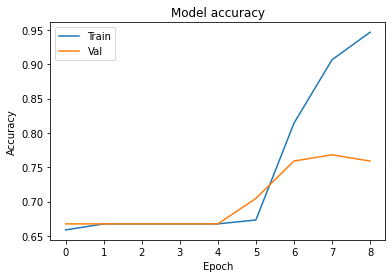

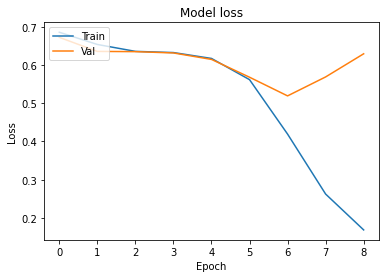

In [29]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [31]:
pred_noemb_val_y = model_CNN.predict([val_X], batch_size=1024, verbose=1)
print(pred_noemb_val_y)

2/2 [==============================] - 0s 30ms/step
[[0.05463868]
 [0.4876508 ]
 [0.06260645]
 ...
 [0.36353588]
 [0.5378081 ]
 [0.10361166]]


In [35]:
# validation the model(confusion matrix)
def cnn_confusion_matrix(pred_noemb_val_y, val_y):
    pred_val_y = pred_noemb_val_y > 0.5
    tn, fp, fn, tp = confusion_matrix(pred_val_y, val_y).ravel()
    print('tn', tn, 'fp', fp, 'fn', fn, 'tp', tp)

    lstm_acc = accuracy_score(pred_val_y, val_y)
    lstm_precision = precision_score(pred_val_y, val_y)
    lstm_recall = recall_score(pred_val_y, val_y)
    lstm_f1_score = f1_score(pred_val_y, val_y)
    return lstm_acc, lstm_precision, lstm_recall, lstm_f1_score

cnn_acc, cnn_precision, cnn_recall, cnn_f1_score = cnn_confusion_matrix(pred_noemb_val_y, val_y)
print('cnn_acc: ',cnn_acc, ', cnn_precision: ', cnn_precision, ', cnn_recall: ', cnn_recall, ', cnn_f1_score', cnn_f1_score)

tn 802 fp 237 fn 82 tp 203
cnn_acc:  0.7590634441087614 , cnn_precision:  0.46136363636363636 , cnn_recall:  0.712280701754386 , cnn_f1_score 0.5599999999999999


3/3 [==============================] - 0s 51ms/step
[[0.05463865]
 [0.48765087]
 [0.06260645]
 ...
 [0.36353588]
 [0.5378081 ]
 [0.10361166]]


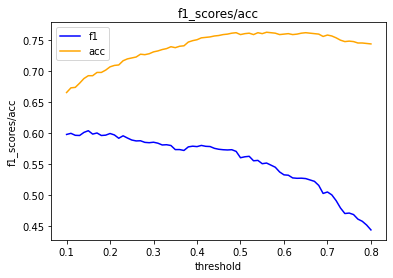

In [36]:
# validation the model(f1-score)
pred_noemb_val_y = model_CNN.predict([val_X], batch_size=512, verbose=1)
print(pred_noemb_val_y)
threshes=[]
f1_scores=[]
accuracy_scores=[]
for thresh in np.arange(0.1, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    threshes.append(thresh)
    # logging.info("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    f1_scores.append(metrics.f1_score(val_y, (pred_noemb_val_y>thresh).astype(int)))
    # logging.info("Accuracy at threshold {0} is {1}".format(thresh, metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int))))
    accuracy_scores.append(metrics.accuracy_score(val_y, (pred_noemb_val_y>thresh).astype(int)))

# plot two measures
plt.plot(threshes, f1_scores, color='blue', label='f1')
plt.plot(threshes, accuracy_scores, color='orange', label='acc')
plt.title('f1_scores/acc')
plt.ylabel('f1_scores/acc')
plt.xlabel('threshold')
plt.legend()
plt.show()

CNN visualiazation

In [0]:
class_idx = np.argmax(pred_noemb_val_y[0]) #not needed in this case as only two classes
class_output = model_CNN.output[:, class_idx]
last_conv_layer = model_CNN.get_layer("Conv2")

In [39]:
print(class_idx)
print(class_output)

0
Tensor("strided_slice_1:0", shape=(None,), dtype=float32)


In [0]:
from keras import backend as K 
grads = K.gradients(class_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads)
iterate = K.function([model_CNN.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([val_X])

In [0]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap,0)
heatmap /= np.max(heatmap)#normalise values in the prediction

In [57]:
from IPython.display import HTML
norm_len = max_len/last_conv_layer.output_shape[1] # find the ratio of the text vs the conv layer length
html = ""

for i in range(15):
    if pred_noemb_val_y[i]>0.5:
        pred = 'offensive'
    else:
        pred = 'normal'
    
    if val_y[i] == 1:
        act = 'offensive'
    else:
        act = 'normal'

    if pred == act:
        ans = 'Correct'
    else:
        ans = 'Wrong'
    
    html += "<span><h3>{} : prediction is a {} tweet, and actucally it's a {}".format(ans, pred, act)

    html += "<small><br>Confidence: {:.0f}%<br><br></small></h3></span>".format(abs(((pred_noemb_val_y[i][0]*100)-50)*2))
    for j,i in enumerate(tokenizer.sequences_to_texts(val_X)[i].split()):
        html += "<span style='background-color:rgba({},0,150,{})'>{} </span>".format(heatmap[math.floor(j/norm_len)]*255,heatmap[math.floor(j/norm_len)]-0.3,i)
HTML(html)

Credit to \\
https://towardsdatascience.com/viewing-text-through-the-eyes-of-a-machine-db30c744ee17

# Prediction 2
